# Light Safety  
This will serve as my notes for the paper "Maintaining ocular safety with light exposure, focusing on devices for optogenetic stimulation". I will also try to include some code to calculate how far below safety limits we are, so that we can compute this easily.  



## Exposure Limits for Single Pulse Stimulation  
For visible light (400nm<lambda<700nm), the "maximum permissible exposure" (MPE), at the *corneal* plane, is expressed in units: W/cm^2, J/cm^2, Wcm^-2 * sr ^ -1, J cm ^ -2 * sr ^ -1. There are 2 sources of damage: 1) thermal and 2) photochemical. If exposure is greater than 0.7s and wavelength is between 400nm and 600nm, then both need to be calculated. For values outside this range, accounting for thermal limits is sufficient.  
### Thermal Limits  
Thermal damage can occurr from two sources. The light absorbed by the retinal pigment ephitelium (RPE) increases its temperature, which can result in protein denaturation. The other type is dubbed "theroacoustic" and results from pulses lasting shorter than ~1ns. The combined thermal limits for light 400nm<lambda<700nm are the following:  

In [20]:
import matplotlib.pyplot as plt

#depends on size of stimulus in terms of visual angle
def Ce(t, alpha, alpha_min=1.5):
    if alpha < alpha_min:
        return 1;
    if t < 625 * 10*1e-6:
        alpha_max = 5;
    elif t < 0.25:
        alpha_max = 200 * t ** 0.5;
    elif 0.25 <= t:
        alpha_max = 100;
    else:
        raise Exception('value of t is not valid.');
        
    if alpha < alpha_max:
        return alpha/alpha_min;
    else:
        return alpha ** 2 / (alpha_min * alpha_max);


In [136]:
import numpy as np
alphas = np.linspace(0,100,200)
ts = np.linspace(0,1,100)

out = np.zeros((len(alphas), len(ts)));
for i_a, a in enumerate(alphas):
    for i_t, t in enumerate(ts):
        out[i_a, i_t] = Ce(t, a)

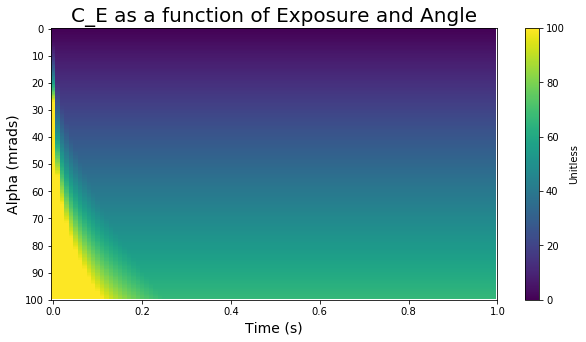

In [137]:
def plot_asfunc_alpha_time(out, colorbar_label, t_max = 1, angle_max = 100, vmax = 100, title = 'C_E as a function of Exposure and Angle'):
    fig, ax = plt.subplots(1,1,figsize=(10,5));
    im = ax.imshow(out, aspect='auto', vmin=0, vmax=vmax)

    ax.set_xticks(np.linspace(0,out.shape[1], 6))
    ax.set_xticklabels(['%.1f'%w for w in np.linspace(0,t_max,6)])

    ax.set_yticks(np.linspace(0, out.shape[0], 11))
    ax.set_yticklabels(['%i'%w for w in np.linspace(0,angle_max, 11)])

    ax.set_title(title, fontsize=20)
    ax.set_xlabel('Time (s)', fontsize=14)
    ax.set_ylabel('Alpha (mrads)', fontsize=14)
    cbar = plt.colorbar(im)
    cbar.set_label(colorbar_label)
    plt.show()
    
plot_asfunc_alpha_time(out, 'Unitless', vmax=100)

In [138]:
t_min = 5*10e-6; #seconds

def calculate_T2(alpha, alpha_min = 1.5):
    if alpha < alpha_min:
        return 10;
    elif alpha <= 100:
        return 10 ** (1 + (alpha - 1.5)/98.5);
    else: 
        return 100;
    

#thermal limits
first_level = lambda t, Ce: 1e-7 * Ce if (10e-13 <= t < 10e-11) else 0;
second_level = lambda t, Ce: 2 * Ce * 10*1e-7 if (10e-11 <= t < t_min) else 0;
third_level = lambda t, Ce, T2: 1.8 * 10*1e-3 * Ce * (t ** 0.75) if (t_min <= t < T2) else 0;
fourth_level = lambda t, Ce, T2: 1.8 * 10*1e-3 * Ce * t * (T2 ** -0.25) if (T2 <= t <= 3 * 10 * 1e4) else 0;
thermal_limits = lambda t, Ce, T2: first_level(t,Ce) +  second_level(t, Ce) + third_level(t, Ce, T2) + fourth_level(t, Ce, T2);

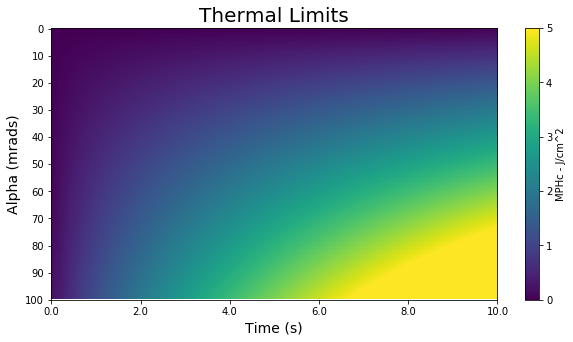

In [139]:
#new values for time, it should be able to go longer. 
ts = np.linspace(0,10,1000)

out = np.zeros((len(alphas), len(ts)));
for i_a, a in enumerate(alphas):
    for i_t, t in enumerate(ts):
        CE = Ce(t, a);
        T2 = calculate_T2(a);
        out[i_a, i_t] = thermal_limits(t, CE, T2);
plot_asfunc_alpha_time(out, 'MPHc - J/cm^2', t_max = 10, vmax = 5, title='Thermal Limits')

The thermal limits can be calculated as a function of time (duration of exposure), and degree of visual field (usually 10 for fovea only). Given these two paramters, above is the corresponding plot, where the resulting unit is J/cm^2. These correspond to the values where thermal damage starts to occurr, both from thermal and thermoacoustic damage. 

### Photochemical Limits  
Photochemical damage is thought to be the result of a photo- oxidative insult to the photoreceptors and to lipofuscin pigments in the RPE, which occur at short visible wavelengths (400 nm 6 k < 600 nm) and for exposure durations longer than 0.7 seconds.
Photochemical damage can be calculated as a function of exposure time (t), angle (alpha), and wavelenght (lambda). We can plot it as follows:

In [160]:
def calculate_gamma(t):
    if t >= 0.7 and t < 100:
        return 11
    elif t>=100 and t < 1e4:
        return 1.1 * (t ** 0.5)
    elif t >= 1e4 and t < 3 * 1e4:
        return 110
    else:
        return None

def calculate_CB(lambd):
    if lambd >= 400 and lambd < 450:
        return 1
    elif lambd >= 450 and lambd < 600:
        return np.power(10, 0.02 * (lambd-450))
    
def photochemical_MPH(t, alpha, lambd):
    if t >= 0.7 and t < 100:
        if alpha <= 11:
            return 1e-2 * calculate_CB(lambd)
        else:
            return 7.85 * 1e-5 * calculate_CB(lambd) * (max(alpha, calculate_gamma(t)) ** 2)
    elif t >= 100 and t < 1e4:
        return 1e-4 * calculate_CB(lambd) * t
    elif t >= 1e4 and t < 3 * 1e4:
        return 7.85 * 1e-9 * calculate_CB(lambd) * (max(alpha, calculate_gamma(t)) ** 2) * t
    else:
        return None

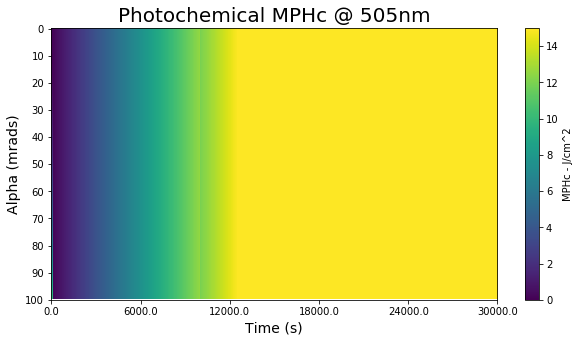

In [164]:
ts = np.linspace(7,3 * 1e4,1000)
out = np.zeros((len(alphas), len(ts)));

lambd = 505;

for i_a, a in enumerate(alphas):
    for i_t, t in enumerate(ts):
        out[i_a, i_t] = photochemical_MPH(t, a, lambd);
        
plot_asfunc_alpha_time(out, 'MPHc - J/cm^2', t_max = 3 * 1e4, vmax = 15, title='Photochemical MPHc @ 505nm')

## Exposure Limits for Repetitive Pulse Stimulations  



## Modifications for Eye and Head Movements  

## Corneal to Retinal Conversions  

